In [18]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsRegressor
import pickle

In [19]:
flights = pd.read_csv('Final_FLights_Cords.csv')

In [20]:
flights = flights.dropna(subset=['ARR_DELAY'])

In [21]:
delay_columns = ['DELAY_DUE_CARRIER', 'DELAY_DUE_WEATHER', 'DELAY_DUE_NAS', 'DELAY_DUE_SECURITY', 'DELAY_DUE_LATE_AIRCRAFT']

flights[delay_columns] = flights[delay_columns].fillna(0).infer_objects(copy=False)

In [22]:
NAs = pd.concat([flights.isnull().sum()], axis = 1, keys = ['flights'])
NAs[NAs.sum(axis=1) > 0]

,flights
CANCELLATION_CODE,2913802


In [23]:
def convert_to_hhmm(time_value):
    if isinstance(time_value, str) and len(time_value) == 4:
        return time_value
    elif pd.isnull(time_value):
        return '0000'
    elif isinstance(time_value, (int, float)):
        return f"{int(time_value):04d}"
    elif isinstance(time_value, time):
        return time_value.strftime('%H%M')
    else:
        raise ValueError("Unexpected time format")

In [24]:
flights['DEP_TIME'] =flights['DEP_TIME'].apply(convert_to_hhmm)
flights['ARR_TIME'] = flights['ARR_TIME'].apply(convert_to_hhmm)

In [25]:
flights['DEP_HOUR'] = flights['DEP_TIME'].str[:2].astype(int)
flights['ARR_HOUR'] = flights['ARR_TIME'].str[:2].astype(int)

In [26]:
import calendar
flights['FL_DATE'] = pd.to_datetime(flights['FL_DATE'])
flights['MONTH'] = flights['FL_DATE'].dt.month
flights['DAY_OF_WEEK'] = flights['FL_DATE'].dt.dayofweek
flights['MONTH_NAME'] = flights['MONTH'].apply(lambda x: calendar.month_name[x])


flights['DAY_NAME'] = flights['DAY_OF_WEEK'].apply(lambda x: calendar.day_name[x-1])


flights.drop(['MONTH', 'DAY_OF_WEEK'], axis=1, inplace=True)

In [27]:
flights.head(2)

,FL_DATE,AIRLINE,AIRLINE_DOT,AIRLINE_CODE,DOT_CODE,FL_NUMBER,ORIGIN,ORIGIN_CITY,DEST,DEST_CITY,...,DELAY_DUE_SECURITY,DELAY_DUE_LATE_AIRCRAFT,o_latitude,o_longitude,d_latitude,d_longitude,DEP_HOUR,ARR_HOUR,MONTH_NAME,DAY_NAME
0,2019-01-09,United Air Lines Inc.,United Air Lines Inc.: UA,UA,19977,1562,FLL,"Fort Lauderdale, FL",EWR,"Newark, NJ",...,0.0,0.0,26.072599,-80.152702,40.692501,-74.168701,11,14,January,Tuesday
1,2022-11-19,Delta Air Lines Inc.,Delta Air Lines Inc.: DL,DL,19790,1149,MSP,"Minneapolis, MN",SEA,"Seattle, WA",...,0.0,0.0,44.882000,-93.221802,47.449001,-122.308998,21,23,November,Friday


In [28]:
def determine_delay_reason(row):
    reasons = []
    if row['DELAY_DUE_CARRIER'] > 0:
        reasons.append('CARRIER')
    if row['DELAY_DUE_WEATHER'] > 0:
        reasons.append('WEATHER')
    if row['DELAY_DUE_NAS'] > 0:
        reasons.append('NAS')
    if row['DELAY_DUE_SECURITY'] > 0:
        reasons.append('SECURITY')
    if row['DELAY_DUE_LATE_AIRCRAFT'] > 0:
        reasons.append('LATE_AIRCRAFT')
    
    if len(reasons) > 0:
        return ', '.join(reasons)
    else:
        return 'NO_DELAY'

In [29]:
flights['DELAY_REASON'] = flights.apply(determine_delay_reason, axis=1)

In [30]:
from sklearn.preprocessing import MultiLabelBinarizer
flights['DELAY_REASON'] = flights['DELAY_REASON'].astype(str)


flights['DELAY_REASON'] = flights['DELAY_REASON'].str.split(', ')

mlb = MultiLabelBinarizer()
delay_reasons_encoded = pd.DataFrame(mlb.fit_transform(flights['DELAY_REASON']), columns=mlb.classes_, index=flights.index)

flights = pd.concat([flights, delay_reasons_encoded], axis=1)

In [31]:
flights['TOTAL_DELAY'] = flights['ARR_DELAY'] + flights['DEP_DELAY']


In [32]:
flights.head(2)

,FL_DATE,AIRLINE,AIRLINE_DOT,AIRLINE_CODE,DOT_CODE,FL_NUMBER,ORIGIN,ORIGIN_CITY,DEST,DEST_CITY,...,MONTH_NAME,DAY_NAME,DELAY_REASON,CARRIER,LATE_AIRCRAFT,NAS,NO_DELAY,SECURITY,WEATHER,TOTAL_DELAY
0,2019-01-09,United Air Lines Inc.,United Air Lines Inc.: UA,UA,19977,1562,FLL,"Fort Lauderdale, FL",EWR,"Newark, NJ",...,January,Tuesday,[NO_DELAY],0,0,0,1,0,0,-18.0
1,2022-11-19,Delta Air Lines Inc.,Delta Air Lines Inc.: DL,DL,19790,1149,MSP,"Minneapolis, MN",SEA,"Seattle, WA",...,November,Friday,[NO_DELAY],0,0,0,1,0,0,-11.0


In [33]:
flights.to_csv('Cleaned2.csv')

In [34]:
import joblib
features_dep_delay = ['ORIGIN', 'AIRLINE_CODE', 'DEST', 'DEP_HOUR', 'ARR_HOUR', 'AIR_TIME']
target_dep_delay = 'DEP_DELAY'

X_dep = flights[features_dep_delay]
y_dep = flights[target_dep_delay]

# Split the data
X_train_dep, X_test_dep, y_train_dep, y_test_dep = train_test_split(X_dep, y_dep, test_size=0.2, random_state=42)

# Preprocessing pipeline
preprocessor_dep = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(handle_unknown='ignore'), ['ORIGIN', 'AIRLINE_CODE', 'DEST']),
        ('num', StandardScaler(), ['DEP_HOUR', 'ARR_HOUR', 'AIR_TIME'])
    ]
)

# Model pipeline
pipeline_dep = Pipeline(steps=[
    ('preprocessor', preprocessor_dep),
    ('regressor', LinearRegression())
])

# Train the model
pipeline_dep.fit(X_train_dep, y_train_dep)

# Save the model
with open('dep_delay_model.pkl', 'wb') as file:
    pickle.dump(pipeline_dep, file)

In [35]:
y_pred = pipeline_dep.predict(X_test_dep)
mae = mean_absolute_error( y_test_dep, y_pred)
mse = mean_squared_error( y_test_dep, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score( y_test_dep, y_pred)

print(f'MAE: {mae}')
print(f'MSE: {mse}')
print(f'RMSE: {rmse}')
print(f'R2: {r2}')

MAE: 20.232822505834754
MSE: 2346.2354694232445
RMSE: 48.437954843523734
R2: 0.02770605417738725


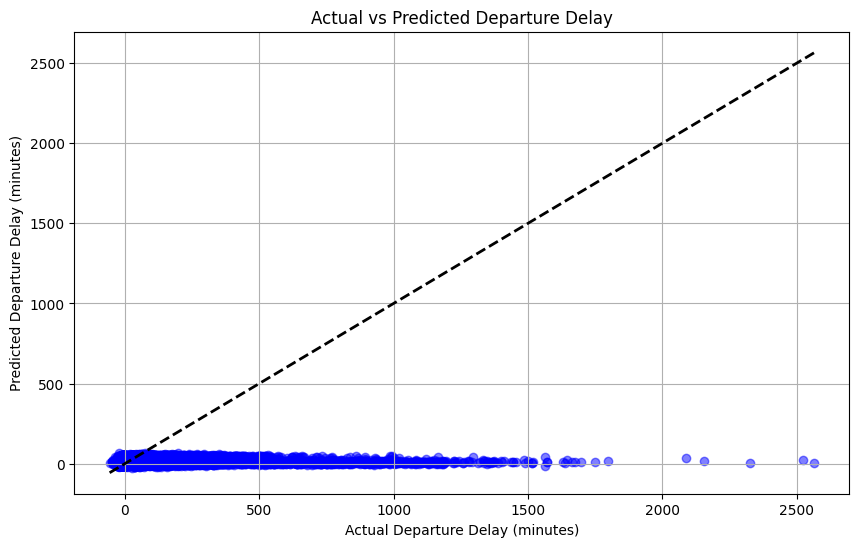

In [36]:
plt.figure(figsize=(10, 6))
plt.scatter(y_test_dep, y_pred, color='blue', alpha=0.5)
plt.plot([y_test_dep.min(), y_test_dep.max()], [y_test_dep.min(), y_test_dep.max()], 'k--', lw=2)
plt.xlabel('Actual Departure Delay (minutes)')
plt.ylabel('Predicted Departure Delay (minutes)')
plt.title('Actual vs Predicted Departure Delay')
plt.grid(True)
plt.show()

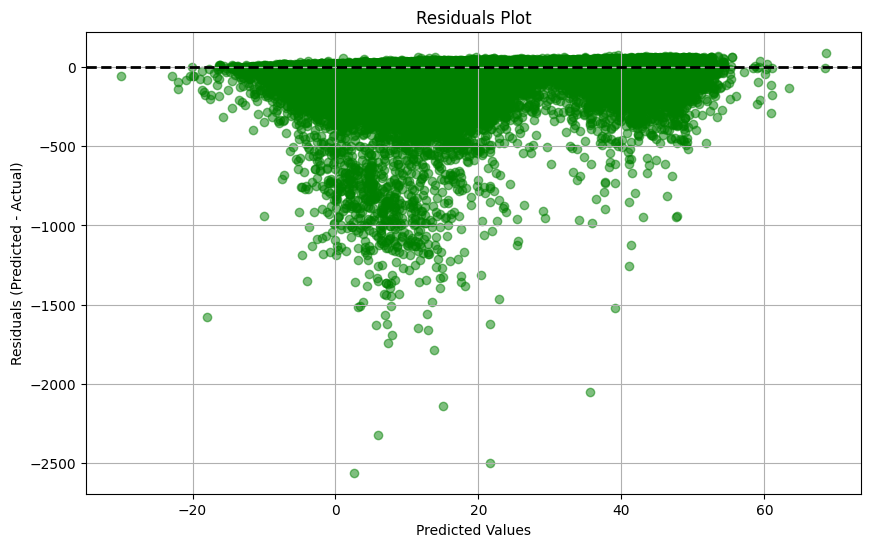

In [37]:
residuals = y_pred - y_test_dep


plt.figure(figsize=(10, 6))
plt.scatter(y_pred, residuals, color='green', alpha=0.5)
plt.axhline(y=0, color='k', linestyle='--', linewidth=2)
plt.xlabel('Predicted Values')
plt.ylabel('Residuals (Predicted - Actual)')
plt.title('Residuals Plot')
plt.grid(True)
plt.show()

In [38]:

features_arr_delay = features_dep_delay + ['DEP_DELAY']
target_arr_delay = 'ARR_DELAY'

X_arr = flights[features_arr_delay + [target_arr_delay]]
y_arr = flights[target_arr_delay]

# Split the data
X_train_arr, X_test_arr, y_train_arr, y_test_arr = train_test_split(X_arr, y_arr, test_size=0.2, random_state=42)

# Preprocessing pipeline
preprocessor_arr = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(handle_unknown='ignore'), ['ORIGIN', 'AIRLINE_CODE', 'DEST']),
        ('num', StandardScaler(), ['DEP_HOUR', 'ARR_HOUR', 'AIR_TIME', 'DEP_DELAY'])
    ]
)

# Model pipeline
pipeline_arr = Pipeline(steps=[
    ('preprocessor', preprocessor_arr),
    ('regressor', LinearRegression())
])

# Train the model
pipeline_arr.fit(X_train_arr, y_train_arr)

# Save the model
with open('arr_delay_model.pkl', 'wb') as file:
    pickle.dump(pipeline_arr, file)


In [39]:
y_pred = pipeline_arr.predict(X_test_arr)
mae = mean_absolute_error( y_test_arr, y_pred)
mse = mean_squared_error( y_test_arr, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score( y_test_arr, y_pred)

print(f'MAE: {mae}')
print(f'MSE: {mse}')
print(f'RMSE: {rmse}')
print(f'R2: {r2}')

MAE: 9.253191054235906
MSE: 176.57081556599536
RMSE: 13.287995167292745
R2: 0.9327929472768509


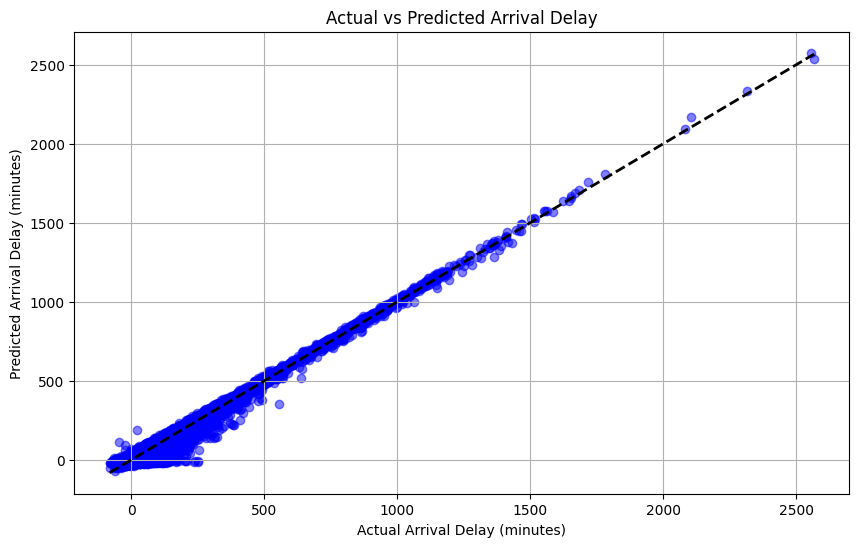

In [40]:
plt.figure(figsize=(10, 6))
plt.scatter(y_test_arr, y_pred, color='blue', alpha=0.5)
plt.plot([y_test_arr.min(), y_test_arr.max()], [y_test_arr.min(), y_test_arr.max()], 'k--', lw=2)
plt.xlabel('Actual Arrival Delay (minutes)')
plt.ylabel('Predicted Arrival Delay (minutes)')
plt.title('Actual vs Predicted Arrival Delay')
plt.grid(True)
plt.show()

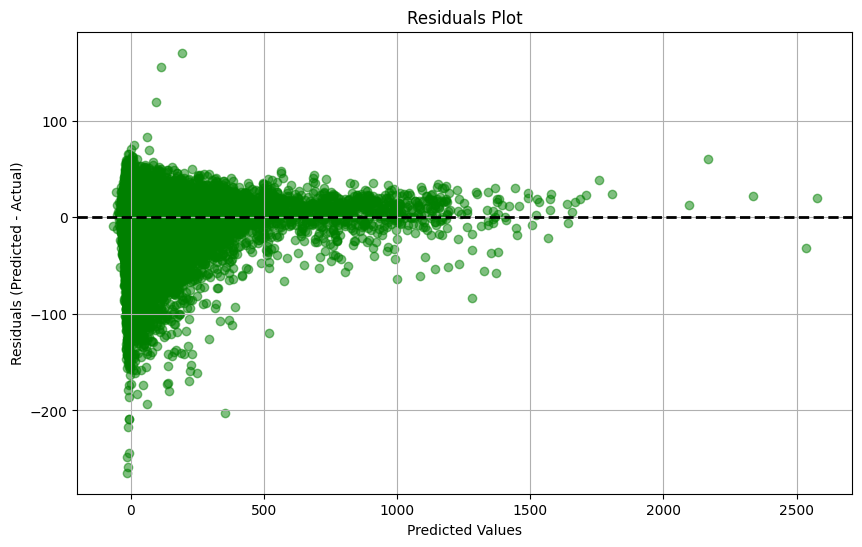

In [41]:
residuals = y_pred - y_test_arr


plt.figure(figsize=(10, 6))
plt.scatter(y_pred, residuals, color='green', alpha=0.5)
plt.axhline(y=0, color='k', linestyle='--', linewidth=2)
plt.xlabel('Predicted Values')
plt.ylabel('Residuals (Predicted - Actual)')
plt.title('Residuals Plot')
plt.grid(True)
plt.show()

In [42]:
delay_threshold = 15
flights['DELAYED'] = (flights['ARR_DELAY'] > delay_threshold).astype(int)
delayed_data = flights[flights['DELAYED'] == 1]

In [43]:
from sklearn.impute import SimpleImputer
features = ['ORIGIN', 'AIRLINE_CODE', 'DEST', 'DEP_HOUR', 'ARR_HOUR', 'AIR_TIME', 'DEP_DELAY', 'ARR_DELAY','TOTAL_DELAY'  ]

target_variables = ['CARRIER', 'LATE_AIRCRAFT', 'NAS', 'SECURITY', 'WEATHER']


X_reasons = delayed_data[features]
y_reasons = delayed_data[target_variables]

X_train, X_test, y_train, y_test = train_test_split(X_reasons, y_reasons, test_size=0.2, random_state=42)
from sklearn.impute import SimpleImputer
numerical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler())
])


categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, [ 'DEP_HOUR', 'ARR_HOUR', 'AIR_TIME', 'DEP_DELAY', 'ARR_DELAY','TOTAL_DELAY']),
        ('cat', categorical_transformer, ['ORIGIN', 'AIRLINE_CODE', 'DEST'])
    ])


In [44]:
from sklearn.multioutput import MultiOutputClassifier
from sklearn.linear_model import LogisticRegression
classifier = MultiOutputClassifier(LogisticRegression(max_iter=1000, random_state=42))

pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                           ('classifier', classifier)])

pipeline.fit(X_train, y_train)


y_pred = pipeline.predict(X_test)

In [45]:
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, classification_report, confusion_matrix
print("Accuracy Score:", accuracy_score(y_test, y_pred))
print("Precision Score:", precision_score(y_test, y_pred, average='weighted'))
print("Recall Score:", recall_score(y_test, y_pred, average='weighted'))
print("F1 Score:", f1_score(y_test, y_pred, average='weighted'))


Accuracy Score: 0.40625667100079565
Precision Score: 0.7239881257476202
Recall Score: 0.7509526683860426
F1 Score: 0.7321262168410563


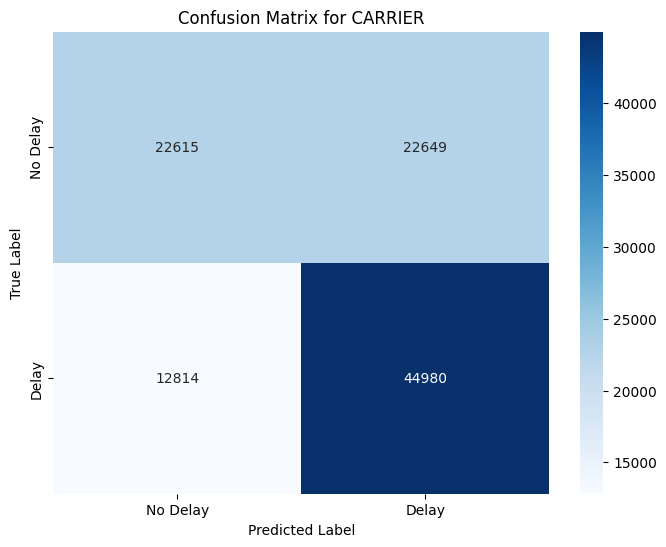

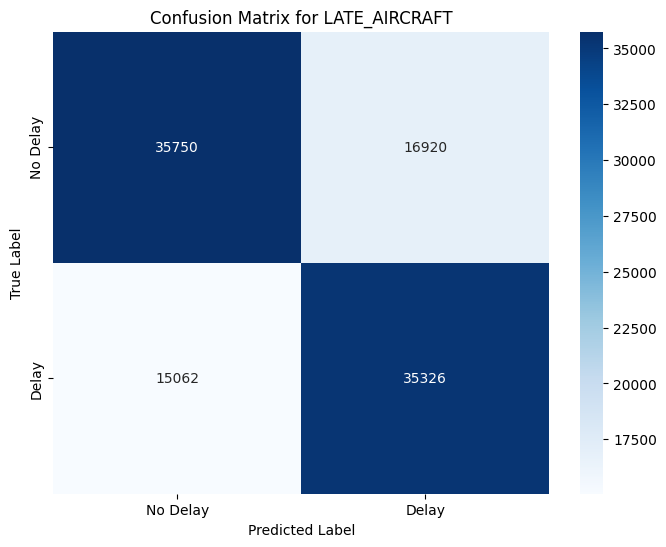

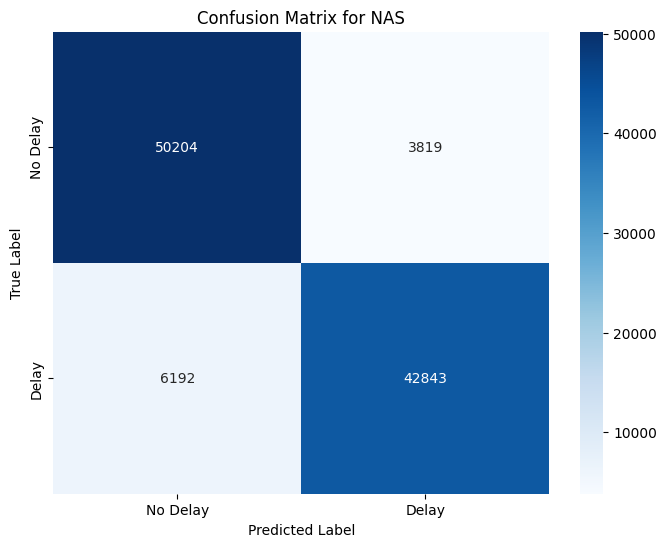

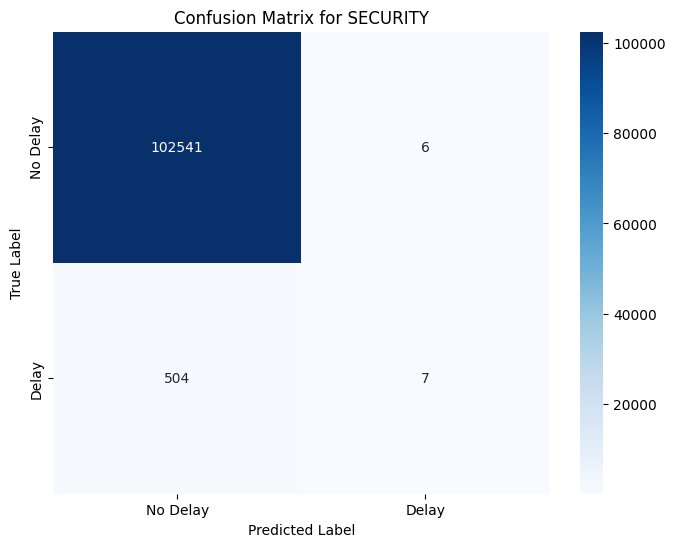

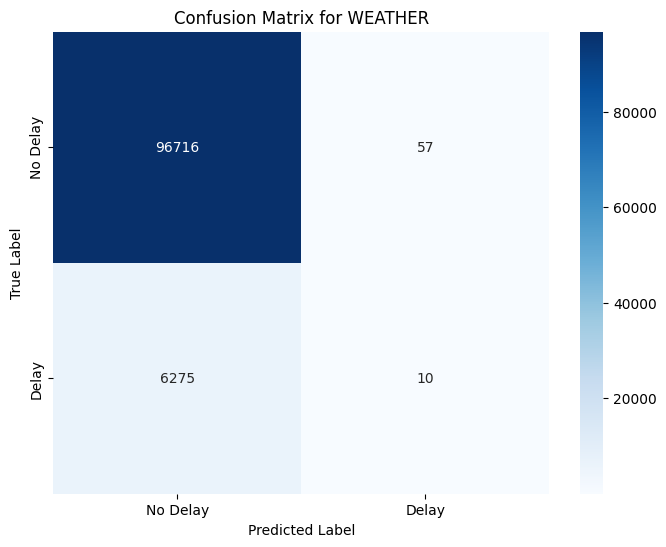

In [46]:
def plot_confusion_matrix(y_true, y_pred, title):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=True,
                xticklabels=['No Delay', 'Delay'], yticklabels=['No Delay', 'Delay'])
    plt.title(title)
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.show()
delay_reasons = ['CARRIER', 'LATE_AIRCRAFT', 'NAS', 'SECURITY', 'WEATHER']
for reason in delay_reasons:
    plot_confusion_matrix(y_test[reason], y_pred[:, delay_reasons.index(reason)], f'Confusion Matrix for {reason}')

In [47]:
from xgboost import XGBClassifier
classifier2 = MultiOutputClassifier(XGBClassifier(random_state=42))


pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                           ('classifier', classifier2)])


pipeline.fit(X_train, y_train)


y_pred = pipeline.predict(X_test)
import pickle
with open('reasons_model.pkl', 'wb') as f:
    pickle.dump(pipeline, f)

In [48]:
print("Accuracy Score:", accuracy_score(y_test, y_pred))
print("Precision Score:", precision_score(y_test, y_pred, average='weighted'))
print("Recall Score:", recall_score(y_test, y_pred, average='weighted'))
print("F1 Score:", f1_score(y_test, y_pred, average='weighted'))

Accuracy Score: 0.5064429738593802
Precision Score: 0.7689011802382989
Recall Score: 0.8187338808509081
F1 Score: 0.779799501173973


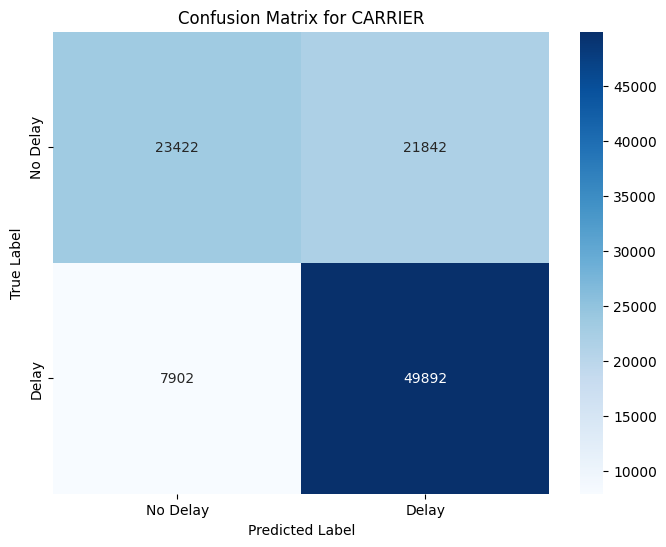

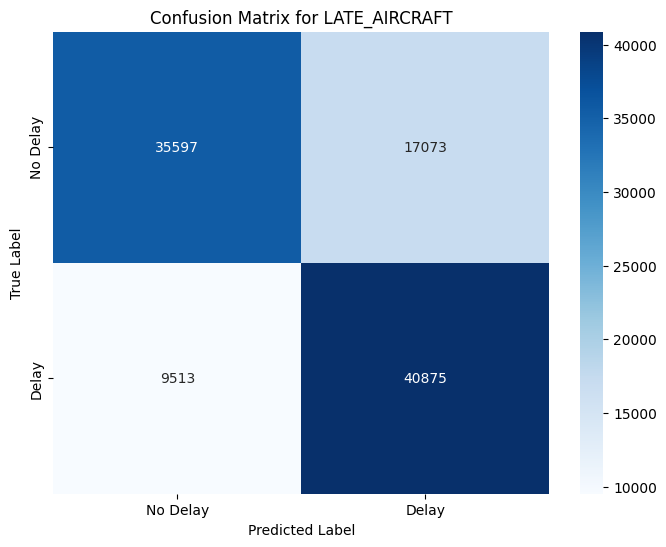

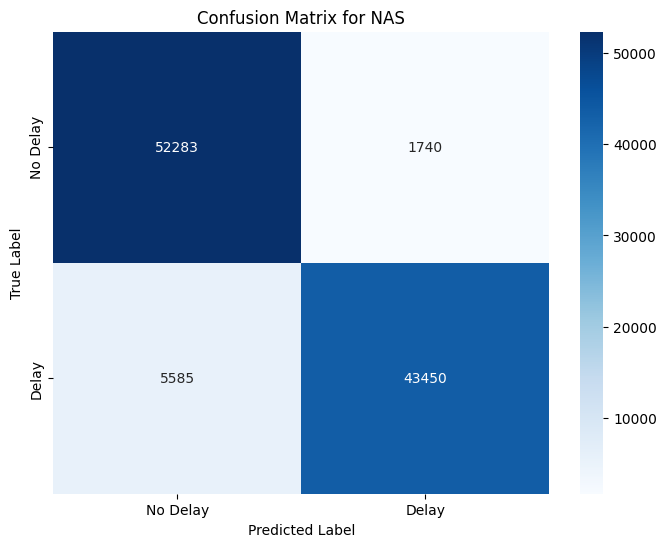

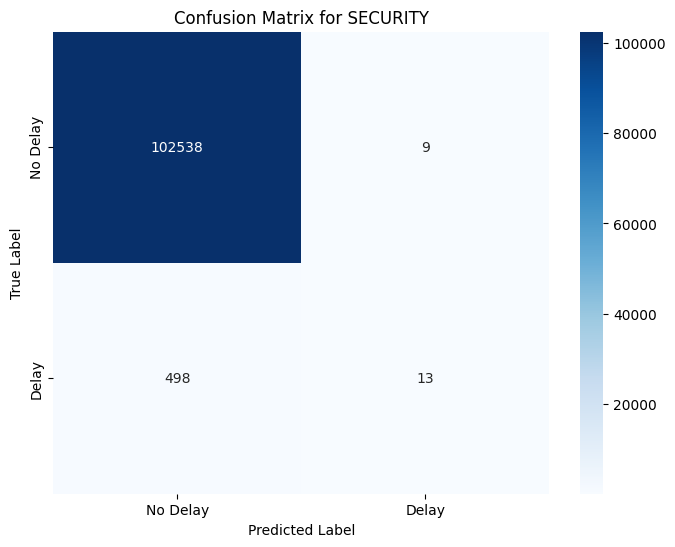

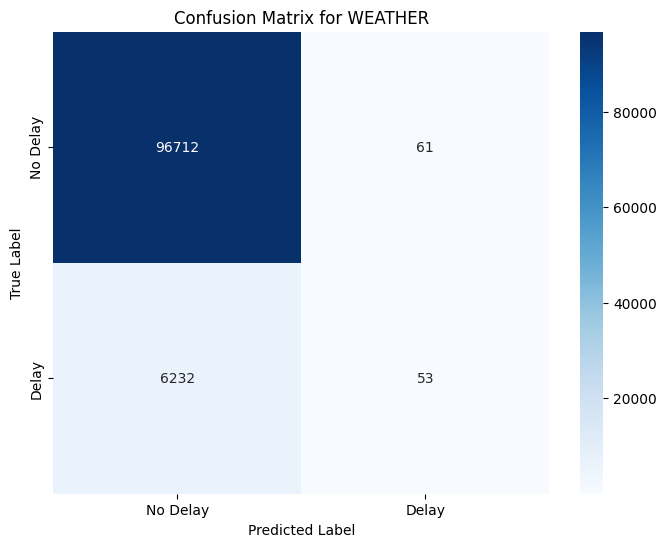

In [49]:
for reason in delay_reasons:
    plot_confusion_matrix(y_test[reason], y_pred[:, delay_reasons.index(reason)], f'Confusion Matrix for {reason}')